In [1]:
# In[1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, DropMissingData
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import LogTransformer
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [16]:
#%%
dataset_dir = '../datasets/titanic/'
jobs = -1
cross_validation = 10

df = pd.read_csv(dataset_dir + 'train.csv')

# Name is not an important feature in our analysis
# Ticket number may indicate being in the same family, but I'll exclude for simplicity
df.drop(['Name', 'Ticket'], axis=1, inplace=True)

FEATURES = ['Cabin', 'Fare', 'Sex', 'Age', 'Parch']

X_train, X_test, y_train, y_test = train_test_split(
    df[FEATURES], # predictive variables
    df['Survived'],               # target
    test_size = 0.2,                # portion of dataset to allocate to test set
    random_state = 0,               # we are setting the seed here
)
X_train

,Cabin,Fare,Sex,Age,Parch
140,NaN,15.2458,female,NaN,2
439,NaN,10.5000,male,31.0,0
817,NaN,37.0042,male,31.0,1
378,NaN,4.0125,male,20.0,0
491,NaN,7.2500,male,21.0,0
...,...,...,...,...,...
835,E49,83.1583,female,39.0,1
192,NaN,7.8542,female,19.0,0
629,NaN,7.7333,male,NaN,0
559,NaN,17.4000,female,36.0,0


In [ ]:
https://scikit-learn.org/stable/modules/impute.html

In [3]:
#%%
class MissingBinaryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        if not isinstance(variables, list):
            raise ValueError('variables should be a list')

        self.variables = variables

    # Trivial method to be compatible with Sklearn pipeline
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.variables:
            X[feature] = X[feature].fillna('Missing')
            X[feature] = np.where(X[feature] == 'Missing', 0, 1)

        return X

In [17]:
X_train_1 = MissingBinaryTransformer(variables=['Cabin']).transform(X_train)
X_train_1

,Cabin,Fare,Sex,Age,Parch
140,0,15.2458,female,NaN,2
439,0,10.5000,male,31.0,0
817,0,37.0042,male,31.0,1
378,0,4.0125,male,20.0,0
491,0,7.2500,male,21.0,0
...,...,...,...,...,...
835,1,83.1583,female,39.0,1
192,0,7.8542,female,19.0,0
629,0,7.7333,male,NaN,0
559,0,17.4000,female,36.0,0


In [18]:
X_train_2 = AddMissingIndicator(missing_only=True, variables=['Age']).fit_transform(X_train_1)
X_train_2

,Cabin,Fare,Sex,Age,Parch,Age_na
140,0,15.2458,female,NaN,2,1
439,0,10.5000,male,31.0,0,0
817,0,37.0042,male,31.0,1,0
378,0,4.0125,male,20.0,0,0
491,0,7.2500,male,21.0,0,0
...,...,...,...,...,...,...
835,1,83.1583,female,39.0,1,0
192,0,7.8542,female,19.0,0,0
629,0,7.7333,male,NaN,0,1
559,0,17.4000,female,36.0,0,0


In [19]:
X_train_3 = MeanMedianImputer(imputation_method='median', variables=['Age']).fit_transform(X_train_2)
X_train_3

,Cabin,Fare,Sex,Age,Parch,Age_na
140,0,15.2458,female,29.0,2,1
439,0,10.5000,male,31.0,0,0
817,0,37.0042,male,31.0,1,0
378,0,4.0125,male,20.0,0,0
491,0,7.2500,male,21.0,0,0
...,...,...,...,...,...,...
835,1,83.1583,female,39.0,1,0
192,0,7.8542,female,19.0,0,0
629,0,7.7333,male,29.0,0,1
559,0,17.4000,female,36.0,0,0


In [4]:
#%%
class GenderBinaryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        if not isinstance(variables, list):
            raise ValueError('variables should be a list')

        self.variables = variables

    # Trivial method to be compatible with Sklearn pipeline
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.variables:
            X[feature] = np.where(X[feature] == 'female', 0, 1)

        return X

In [5]:
#%%
class NonZeroTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        if not isinstance(variables, list):
            raise ValueError('variables should be a list')

        self.variables = variables

    # Trivial method to be compatible with Sklearn pipeline
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.variables:
            X[feature] = X[feature].fillna(int(0))
            X[feature] = np.where(X[feature] < 0.1, 0.1, X[feature])

        return X

In [6]:
#%%
def pipe_func():   
    LR_pipe = Pipeline([
        # -- IMPUTATION --
        ('missing_imputation', MissingBinaryTransformer(variables=['Cabin'])),
        ('missing_indicator', AddMissingIndicator(missing_only=True, variables=['Age'])),
        ('mean_imputation', MeanMedianImputer(imputation_method='median', variables=['Age'])),
    
        # -- TRANSFORMATION --
        ('gender_binarize', GenderBinaryTransformer(variables=['Sex'])),
        ('fare_nonzero', NonZeroTransformer(variables=['Fare'])),
        ('log', LogTransformer(variables=['Fare'])),
    
        # -- SCALING AND PREDICTION -- 
        ('scaler', MinMaxScaler()),
        ('LogisticRegession', LogisticRegression()),],
        verbose = True)
    
    RFR_pipe = Pipeline([
        # -- IMPUTATION --
        ('missing_imputation', MissingBinaryTransformer(variables=['Cabin'])),
        ('missing_indicator', AddMissingIndicator(missing_only=True, variables=['Age'])),
        ('mean_imputation', MeanMedianImputer(imputation_method='median', variables=['Age'])),

        # -- TRANSFORMATION --
        ('gender_binarize', GenderBinaryTransformer(variables=['Sex'])),
        ('fare_nonzero', NonZeroTransformer(variables=['Fare'])),
        ('log', LogTransformer(variables=['Fare'])),

        # -- SCALING AND PREDICTION -- 
        ('scaler', MinMaxScaler()),
        ('RandomForestRegressor', RandomForestRegressor()),],
        verbose = True)
    
    return LR_pipe, RFR_pipe

In [7]:
#%%
def pipe_parm():
    # Set grid search params
    params = {
        'LogisticRegession':{
            'LogisticRegession__penalty': ['l1', 'l2'],
            'LogisticRegession__solver': ['liblinear', 'saga'],
            'LogisticRegession__random_state': [0, 1]},
        'RandomForestRegressor':{
            'RandomForestRegressor__max_features': [4], 
            'RandomForestRegressor__n_estimators': [3, 10, 30],}
    }
    return params

In [14]:
#%%
def plt_keys(pipe, method):    
    print('Best accuracy : %.3f' % pipe.best_score_)
    print('\nBest params:\n',pipe.best_params_)
    
    result = permutation_importance(pipe, X_train, y_train.round(), n_repeats=10,
                                    random_state=42, n_jobs=2)
    sorted_idx = result.importances_mean.argsort()
    
    fig, ax = plt.subplots()
    ax.barh(FEATURES, result.importances[sorted_idx].mean(axis=1).T)
    ax.set_title(f"Permutation Importances of {method}")
    fig.tight_layout()
    plt.show()

In [9]:
#%%
def test_data(pipe):
    new_df = pd.read_csv(dataset_dir +'test.csv')
    new_df.drop(['Name', 'Ticket'], axis=1, inplace=True)
    X_valid = new_df[FEATURES]
    missingdata_imputer = DropMissingData(variables=['Cabin'])
    X_valid = missingdata_imputer.fit_transform(X_valid)
    
    new_preds = pipe.predict(X_valid)
    result = pd.DataFrame(new_preds, columns=["Survived"])
    result['PassengerId'] = new_df['PassengerId']
    result.to_csv('result.csv', index=False)

[Pipeline]  (step 1 of 8) Processing missing_imputation, total=   0.0s
[Pipeline] . (step 2 of 8) Processing missing_indicator, total=   0.0s
[Pipeline] ... (step 3 of 8) Processing mean_imputation, total=   0.0s
[Pipeline] ... (step 4 of 8) Processing gender_binarize, total=   0.0s
[Pipeline] ...... (step 5 of 8) Processing fare_nonzero, total=   0.0s
[Pipeline] ............... (step 6 of 8) Processing log, total=   0.0s
[Pipeline] ............ (step 7 of 8) Processing scaler, total=   0.0s
[Pipeline]  (step 8 of 8) Processing RandomForestRegressor, total=   0.0s
[Pipeline]  (step 1 of 8) Processing missing_imputation, total=   0.0s
[Pipeline] . (step 2 of 8) Processing missing_indicator, total=   0.0s
[Pipeline] ... (step 3 of 8) Processing mean_imputation, total=   0.0s
[Pipeline] ... (step 4 of 8) Processing gender_binarize, total=   0.0s
[Pipeline] ...... (step 5 of 8) Processing fare_nonzero, total=   0.0s
[Pipeline] ............... (step 6 of 8) Processing log, total=   0.0s
[Pi

[Pipeline]  (step 1 of 8) Processing missing_imputation, total=   0.0s
[Pipeline] . (step 2 of 8) Processing missing_indicator, total=   0.0s
[Pipeline] ... (step 3 of 8) Processing mean_imputation, total=   0.0s
[Pipeline] ... (step 4 of 8) Processing gender_binarize, total=   0.0s
[Pipeline] ...... (step 5 of 8) Processing fare_nonzero, total=   0.0s
[Pipeline] ............... (step 6 of 8) Processing log, total=   0.0s
[Pipeline] ............ (step 7 of 8) Processing scaler, total=   0.0s
[Pipeline]  (step 8 of 8) Processing RandomForestRegressor, total=   0.0s
[Pipeline]  (step 1 of 8) Processing missing_imputation, total=   0.0s
[Pipeline] . (step 2 of 8) Processing missing_indicator, total=   0.0s
[Pipeline] ... (step 3 of 8) Processing mean_imputation, total=   0.0s
[Pipeline] ... (step 4 of 8) Processing gender_binarize, total=   0.0s
[Pipeline] ...... (step 5 of 8) Processing fare_nonzero, total=   0.0s
[Pipeline] ............... (step 6 of 8) Processing log, total=   0.0s
[Pi

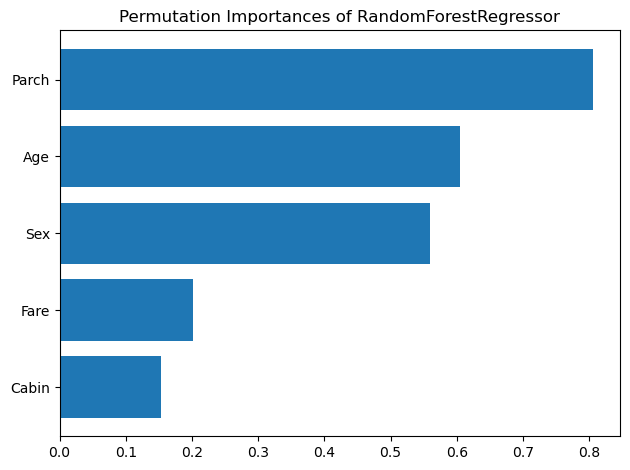

In [20]:
# In[ ]:
if __name__ == '__main__':

    LR_pipe, RFR_pipe = pipe_func()
    params = pipe_parm()
    method = 'RandomForestRegressor' #'LogisticRegession'
    gs_pipe = GridSearchCV(estimator = RFR_pipe, 
                           param_grid = params[method],
                           cv = cross_validation)
    gs_pipe.fit(X_train, y_train)
    plt_keys(gs_pipe, method)
    test_data(gs_pipe)
